<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL/blob/master/FinRL_ensemble_stock_trading_ICAIF_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
# ## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-41gdi4py
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-41gdi4py
     |████████████████████████████████| 153kB 25.8MB/s 
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-l_3lra45/pyfolio
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-l_3lra45/pyfolio
     |████████████████████████████████| 6.3MB 27.1MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
  Created wheel for finrl: filename=finrl-0.3.0-cp37-none-any.whl size=38769 sha256=57cad6d53d142ac9069ef5d3f8766b4423ee7cb6bcbd93cefec163ec0021e900
  Stored in directory: /tmp/pip-ephem-wheel-cache-93jhahj2/wheels/9c/19/bf/c644def96612df1ad42c94d5304966797eaa3221dffc5efe0b
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=be79f8c3ff69b2e818062d9e7ca122a7c2177fd210d89411a6ea663e654ec24c



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent,DRLEnsembleAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [ ]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [ ]:
# from config.py start_date is a string
config.START_DATE

'2000-01-01'

In [ ]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [ ]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-06-20',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2008-12-31,3.070357,3.133571,3.047857,2.621168,607541200,AAPL,2
1,2008-12-31,17.969999,18.750000,17.910000,15.064775,9625600,AXP,2
2,2008-12-31,41.590000,43.049999,41.500000,32.005901,5443100,BA,2
3,2008-12-31,43.700001,45.099998,43.700001,31.262676,6277400,CAT,2
4,2008-12-31,16.180000,16.549999,16.120001,12.102888,37513700,CSCO,2


In [ ]:
df.tail()

,date,open,high,low,close,volume,tic,day
94015,2021-06-14,234.699997,235.220001,232.149994,232.270004,986656,V,0
94016,2021-06-14,57.189999,57.270000,56.935001,57.070000,2770637,VZ,0
94017,2021-06-14,55.099998,55.075001,54.169998,54.539902,590339,WBA,0
94018,2021-06-14,140.929993,140.929993,140.039993,140.220001,1033410,WMT,0
94019,2021-06-14,62.299999,62.779999,62.290001,62.639999,3415815,XOM,0


In [ ]:
df.shape

(94020, 8)

In [ ]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2008-12-31,3.070357,3.133571,3.047857,2.621168,607541200,AAPL,2
1,2008-12-31,17.969999,18.750000,17.910000,15.064775,9625600,AXP,2
2,2008-12-31,41.590000,43.049999,41.500000,32.005901,5443100,BA,2
3,2008-12-31,43.700001,45.099998,43.700001,31.262676,6277400,CAT,2
4,2008-12-31,16.180000,16.549999,16.120001,12.102888,37513700,CSCO,2


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [ ]:
tech_indicators = ['macd',
 'rsi_30',
 'cci_30',
 'dx_30']

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = tech_indicators,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values
NOTE: Beha

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full.sample(5)

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
44590,2013-01-25,IBM,204.449997,205.179993,204.130005,149.229141,3358900.0,4.0,1.753800,62.188802,285.212182,48.193964,53.089731
34242,2012-02-15,JNJ,64.510002,64.949997,64.470001,49.345165,9023400.0,2.0,-0.064815,49.406220,-123.926289,24.610651,18.832488
89299,2017-02-23,NKE,58.110001,58.400002,57.270000,54.669735,12316300.0,3.0,1.204400,63.109817,148.750970,49.919662,28.035344
14562,2010-04-30,JNJ,65.129997,65.339996,64.300003,46.090996,14255900.0,4.0,-0.019782,49.114488,-94.015885,16.185865,44.229784
63417,2014-10-14,WBA,60.740002,61.400002,59.910000,50.916355,8488500.0,1.0,-0.315171,44.788229,-51.379821,4.149420,49.813588


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [ ]:
stock_dimension = len(processed_full.tic.unique())
state_space = 1 + 2*stock_dimension + len(tech_indicators)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 30, State Space: 181


In [ ]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicators,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

* In this notebook, we are training and validating 3 agents (A2C, PPO, DDPG) using Rolling-window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

In [ ]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)
train_start = '2009-01-01'
train_end = '2015-10-01'
val_test_start = '2015-10-01'
val_test_end = '2020-07-20'

ensemble_agent = DRLEnsembleAgent(df=processed_full,
                 train_period=(train_start,train_end),
                 val_test_period=(val_test_start,val_test_end),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [ ]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.01,
                    'learning_rate': 0.0005
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 50_000,
                      "learning_rate": 0.000005,
                      "batch_size": 128
                    }

timesteps_dict = {'a2c' : 30_000, 
                 'ppo' : 100_000, 
                 'ddpg' : 10_000
                 }


timesteps_dict = {'a2c' : 1_000, 
                 'ppo' : 1_000, 
                 'ddpg' : 1_000
                 }

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
65.06420184954358
turbulence_threshold:  58.53457789561306
======Model training from:  2009-01-01 to  2015-10-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.01e+06 |
|    total_cost         | 7.7e+03  |
|    total_reward       | 1.46e+04 |
|    total_reward_pct   | 1.46     |
|    total_trades       | 1517     |
| time/                 |          |
|    fps                | 161      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -42.7    |
|    explained_variance | -0.297   |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | 15.3     |
|    std                | 1        |
|    value_loss         | 0.375   

------------------------------------
| time/                 |          |
|    fps                | 144      |
|    iterations         | 200      |
|    time_elapsed       | 6        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -42.8    |
|    explained_variance | -22.6    |
|    learning_rate      | 0.0005   |
|    n_updates          | 199      |
|    policy_loss        | -102     |
|    std                | 1.01     |
|    value_loss         | 6.38     |
------------------------------------
======Trading from:  2016-04-05 to  2016-07-05
17.027755767988026
turbulence_threshold:  286.9562782260909
======Model training from:  2009-01-01 to  2016-04-05
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.03e+06 |
|    total_cost         | 6.89e+03 |
|    total_reward       | 3.24e+04

148.64723872108536
turbulence_threshold:  58.53457789561306
======Model training from:  2009-01-01 to  2016-10-03
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.1e+06     |
|    total_cost           | 1.08e+03    |
|    total_reward         | 9.67e+04    |
|    total_reward_pct     | 9.67        |
|    total_trades         | 1096        |
| time/                   |             |
|    fps                  | 128         |
|    iterations           | 100         |
|    time_elapsed         | 3           |
|    total_timesteps      | 500         |
| train/                  |             |
|    actor_loss           | 15.8        |
|    approx_kl            | 0.015514828 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    critic_loss          | 12.5        |
|    entropy_loss         | 

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.12e+06    |
|    total_cost           | 1.07e+03    |
|    total_reward         | 1.16e+05    |
|    total_reward_pct     | 11.6        |
|    total_trades         | 921         |
| time/                   |             |
|    fps                  | 143         |
|    iterations           | 100         |
|    time_elapsed         | 3           |
|    total_timesteps      | 500         |
| train/                  |             |
|    actor_loss           | -83.3       |
|    approx_kl            | 0.018647425 |
|    clip_fraction        | 0.235       |
|    clip_range           | 0.2         |
|    critic_loss          | 134         |
|    entropy_loss         | -42.6       |
|    explained_variance   | -35.7       |
|    learning_rate        | 0.0005      |
|    loss                 | 6.17        |
|    n_updates            | 99          |
|    policy_gradient_loss | -0.030

======DDPG Validation from:  2017-07-05 to  2017-10-03
======Best Model Retraining from:  2009-01-01 to  2017-10-03
{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]), 'buffer_size': 50000, 'learning_rate': 5e-06, 'batch_size': 128}
Using cpu device
======Trading from:  2017-10-03 to  2018-01-03
nan
turbulence_threshold:  286.9562782260909
======Model training from:  2009-01-01 to  2017-10-03
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.28e+06    |
|    total_cost           | 3.74e+03    |
|    total_reward         | 2.77e+05    |
|    total_reward_pct     | 27.7        |
|    total_trades         | 

======Trading from:  2018-04-05 to  2018-07-05
nan
turbulence_threshold:  286.9562782260909
======Model training from:  2009-01-01 to  2018-04-05
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cpu device
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.37e+06    |
|    total_cost           | 1.27e+03    |
|    total_reward         | 3.66e+05    |
|    total_reward_pct     | 36.6        |
|    total_trades         | 1272        |
| time/                   |             |
|    fps                  | 136         |
|    iterations           | 100         |
|    time_elapsed         | 3           |
|    total_timesteps      | 500         |
| train/                  |             |
|    actor_loss           | 50.2        |
|    approx_kl            | 0.012256902 |
|    clip_fraction        | 0.227       |
|    clip_range           | 0.2         |
|    critic_loss          | 278       

======DDPG Validation from:  2018-07-05 to  2018-10-03
======Best Model Retraining from:  2009-01-01 to  2018-10-03
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
----------------------------------------
| environment/            |            |
|    portfolio_value      | 1.07e+06   |
|    total_cost           | 2.59e+03   |
|    total_reward         | 6.95e+04   |
|    total_reward_pct     | 6.95       |
|    total_trades         | 929        |
| time/                   |            |
|    fps                  | 153        |
|    iterations           | 1          |
|    time_elapsed         | 13         |
|    total_timesteps      | 2048       |
| train/                  |            |
|    actor_loss           | -423       |
|    approx_kl            | 0.01623707 |
|    clip_fraction        | 0.227      |
|    clip_range           | 0.2        |
|    critic_loss          | 802        |
|    entropy_loss         | -42.6      |
|    ex

======PPO Validation from:  2019-01-04 to  2019-04-05
PPO Sharpe Ratio:  0.442674028996573
======DDPG Training========
{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]), 'buffer_size': 50000, 'learning_rate': 5e-06, 'batch_size': 128}
Using cpu device
======DDPG Validation from:  2019-01-04 to  2019-04-05
======Best Model Retraining from:  2009-01-01 to  2019-04-05
{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]), 'buffer_size': 50000, 'learning_rate': 5e-06, 'batch_size': 128}
Using cpu device
======Trading from:  2019-04-05 to  2019-07-08
nan
tu

-------------------------------------
| environment/          |           |
|    portfolio_value    | 9.39e+05  |
|    total_cost         | 7.91e+03  |
|    total_reward       | -6.14e+04 |
|    total_reward_pct   | -6.14     |
|    total_trades       | 1500      |
| time/                 |           |
|    fps                | 144       |
|    iterations         | 1         |
|    time_elapsed       | 14        |
|    total_timesteps    | 2048      |
| train/                |           |
|    entropy_loss       | -42.7     |
|    explained_variance | -44.6     |
|    learning_rate      | 0.0005    |
|    n_updates          | 200       |
|    policy_loss        | -26.6     |
|    std                | 1         |
|    value_loss         | 1.56      |
-------------------------------------
======PPO Validation from:  2019-07-08 to  2019-10-04
PPO Sharpe Ratio:  -0.09927674223889364
======DDPG Training========
{'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

======A2C Validation from:  2020-01-06 to  2020-04-06
A2C Sharpe Ratio:  -0.4120363107692286
======PPO Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
-------------------------------------
| environment/          |           |
|    portfolio_value    | 7.83e+05  |
|    total_cost         | 7.44e+03  |
|    total_reward       | -2.17e+05 |
|    total_reward_pct   | -21.7     |
|    total_trades       | 1284      |
| time/                 |           |
|    fps                | 140       |
|    iterations         | 1         |
|    time_elapsed       | 14        |
|    total_timesteps    | 2048      |
| train/                |           |
|    entropy_loss       | -42.7     |
|    explained_variance | -8.97     |
|    learning_rate      | 0.0005    |
|    n_updates          | 200       |
|    policy_loss        | 50.4      |
|    std                | 1.01      |
|    value_loss         | 4.98      |
----------------------

In [ ]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2015-10-02,2016-01-04,PPO,-0.396196,-0.315592,-0.3697
1,189,2016-01-04,2016-04-05,A2C,0.31315,0.310705,0.285361
2,252,2016-04-05,2016-07-05,DDPG,0.0166888,6.03448e-05,0.0524238
3,315,2016-07-05,2016-10-03,DDPG,-0.00228507,-0.0262525,0.0377812
4,378,2016-10-03,2017-01-03,DDPG,0.0842088,0.146093,0.324498
5,441,2017-01-03,2017-04-04,DDPG,0.0989313,-0.00655463,0.204108
6,504,2017-04-04,2017-07-05,A2C,0.456911,0.146164,0.319113
7,567,2017-07-05,2017-10-03,DDPG,0.0851777,0.45456,0.511453
8,630,2017-10-03,2018-01-03,DDPG,0.625317,0.498926,0.816116
9,693,2018-01-03,2018-04-05,DDPG,-0.164783,-0.166979,-0.0971064


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
unique_trade_date = processed_full[(processed_full.date > val_test_start)&(processed_full.date <= val_test_end)].date.unique()

In [ ]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.5906602480862464


In [ ]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2016-01-04,NaN,2016-01-04
1,1.000098e+06,2016-01-05,0.000098,2016-01-05
2,9.982350e+05,2016-01-06,-0.001862,2016-01-06
3,9.950237e+05,2016-01-07,-0.003217,2016-01-07
4,9.948886e+05,2016-01-08,-0.000136,2016-01-08


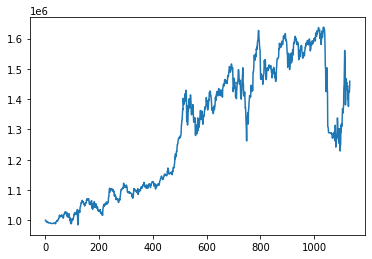

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.087584
Cumulative returns     0.459095
Annual volatility      0.165637
Sharpe ratio           0.590660
Calmar ratio           0.350857
Stability              0.798822
Max drawdown          -0.249630
Omega ratio            1.127499
Sortino ratio          0.810664
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.938521
Daily value at risk   -0.020480
dtype: float64


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1133, 8)
Annual return          0.095357
Cumulative returns     0.506062
Annual volatility      0.205013
Sharpe ratio           0.547962
Calmar ratio           0.257121
Stability              0.772163
Max drawdown          -0.370862
Omega ratio            1.131863
Sortino ratio          0.749922
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.843359
Daily value at risk   -0.025383
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1133, 8)


Start date,2016-01-04
End date,2020-07-02
Total months,53
,Backtest
Annual return,8.286%
Cumulative returns,43.032%
Annual volatility,16.545%
Sharpe ratio,0.56
Calmar ratio,0.33
Stability,0.80
Max drawdown,-24.963%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.96,2020-02-14,2020-05-13,NaT,NaN
1,16.76,2018-10-03,2018-12-24,2019-02-05,90
2,10.91,2019-02-28,2019-03-22,2020-01-16,231
3,10.47,2018-02-01,2018-03-23,2018-07-26,126
4,5.07,2016-08-15,2016-11-04,2016-12-07,83


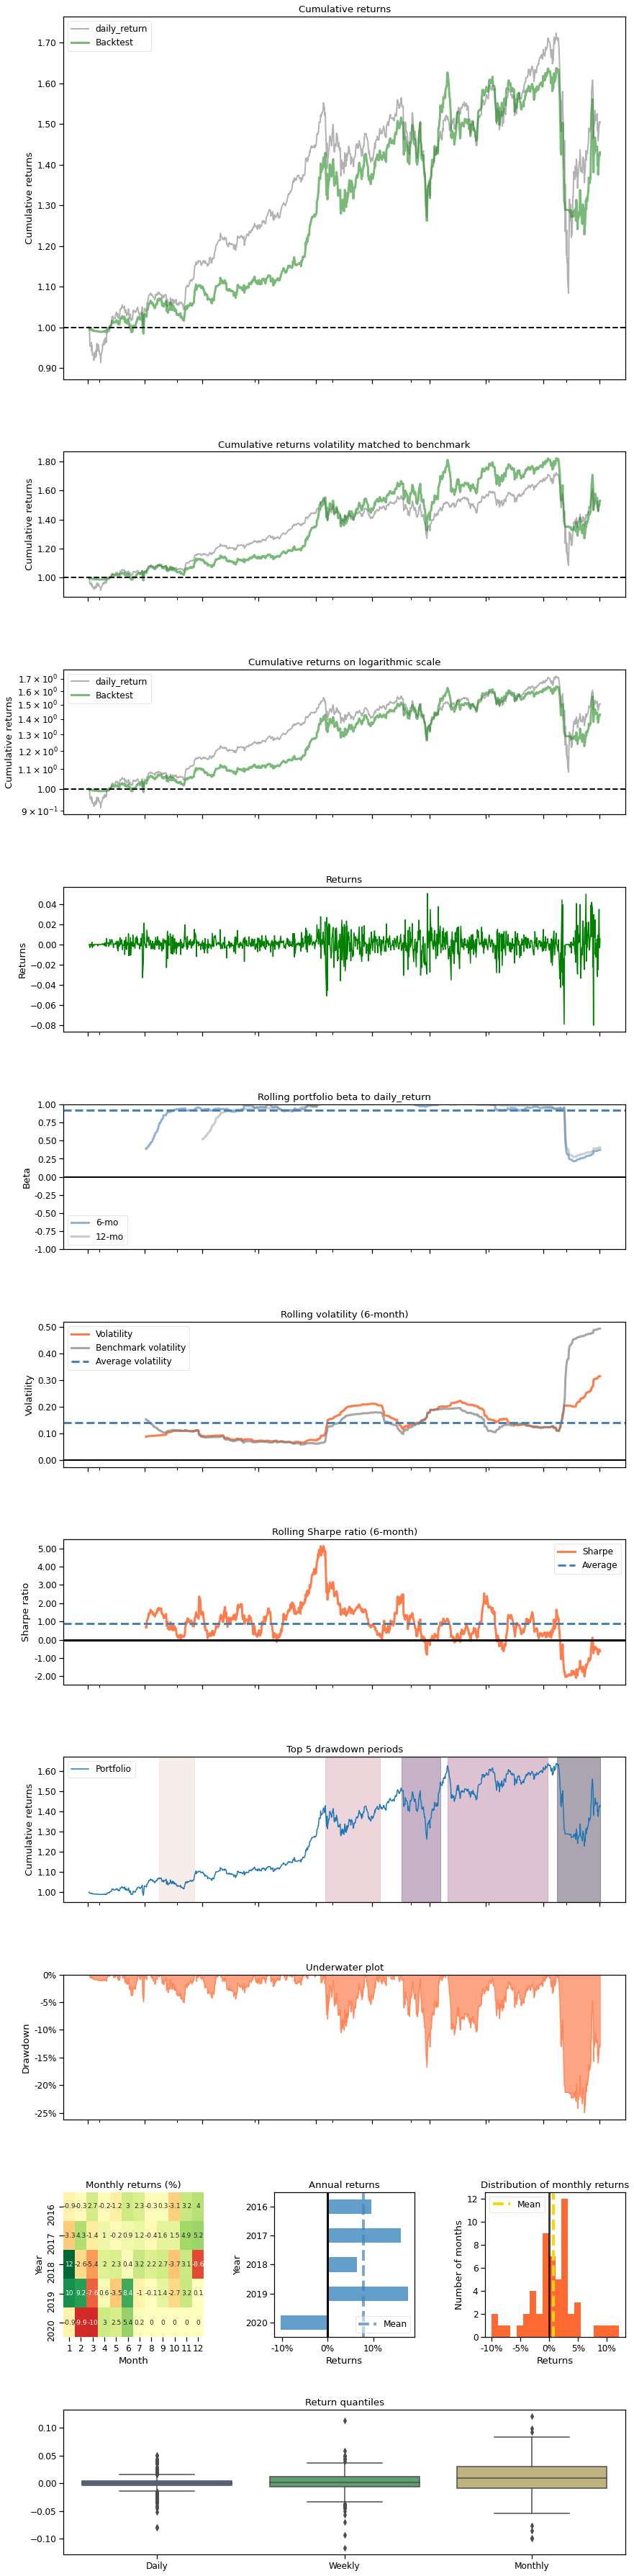

In [ ]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])